<a href="https://colab.research.google.com/github/JosepCristobal/NLPSearchPT/blob/master/NLPSearchPTv02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
!pip install gensim

In [71]:
!pip install stop_words

In [72]:
!pip install pyLDAvis
!pip install spacy
!python -m spacy download en_core_web_sm

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


#2. Hacer Analysis de los tweets del segundo dataset. Que temas aparecen? Como se representan estos temas? De que hablan unos y otros?

Procedemos a los imports y las instalaciones necesarias

In [0]:
import gensim
from os.path import join
import csv
import spacy
from stop_words import get_stop_words
from string import punctuation
import re
import numpy as np
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import pandas as pd
import io
from google.colab import files

import warnings
warnings.filterwarnings('ignore')

In [0]:
stop_words = get_stop_words('en') + list(punctuation) + [' ']
nlp = spacy.load('en_core_web_sm')

In [0]:
import json

In [77]:
#Cargamos nuestro dataset desde nuestro diretorio local a través de la selección de fichero en cuadro de dialogo.
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving BarackObama.json to BarackObama (2).json
User uploaded file "BarackObama.json" with length 373852 bytes


In [105]:
#En este caso, cargaremos un fichero en formato json
ob_names = uploaded['BarackObama.json']
ob_names = json.loads(ob_names)
ob_names['10']

'Michelle and I are so inspired by all the young people who made today’s marches happen. Keep at it. You’re leading us forward. Nothing can stand in the way of millions of voices calling for change.'

In [0]:
df=pd.DataFrame(ob_names.items())

In [107]:
df.head(3)

,0,1
0,0,"“Low plastic stool, cheap but delicious noodle..."
1,1,"“Low plastic stool, cheap but delicious noodle..."
2,2,"This National Gun Violence Awareness Day, show..."


In [108]:
#MAS LIMPIEZA
df[1] = df[1].str.strip()
df.head(3)

,0,1
0,0,"“Low plastic stool, cheap but delicious noodle..."
1,1,"“Low plastic stool, cheap but delicious noodle..."
2,2,"This National Gun Violence Awareness Day, show..."


In [0]:
df.dropna(subset=[1],inplace=True)
#df.head(3)

In [0]:
#Montaremos una serie de filtros para terminar de limpiar nuestros datos
import re
import string
#Utilizamos regex para limpiar nuestro dataset de carácteres especiales, signos de puntuación , etc. 
def clean_text_round1(text):
    #Transformamos las palabras en minusculas, eliminamos los corchete, eliminamos signos de puntuación y palabras con números.
    text = text.lower()
    text = re.sub('\[.*?¿\]\%', ' ', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\w*\d\w*', '', text)
    #Eliminamos signos de puntuación adicionales que en la primera vuelta no fueron tratados
    text = re.sub('[‘’“”…«»]', '', text)
    text = re.sub('\n', ' ', text)

    return text
 


In [111]:
df.isnull().any()

0    False
1    False
dtype: bool

In [0]:
#Limpiamos datos 
#Para la limpieza, invocamos la función creada para ello.
#También aplicamos un filtro utilizando stop words
#get data
documents = []
for row in df.iterrows():
    _, info = row
    _, q = info
    q = re.sub(r'\n','', q)
    q = clean_text_round1(q)
    q = [t.text for t in nlp(q.rstrip(), disable=['parser', 'tagger', 'ner']) if t.text not in stop_words]

    documents.append(q)
    
  

In [0]:
#Limpiamos datos 
#Para la limpieza, invocamos la función creada para ello.
#También aplicamos un filtro utilizando stop words
#get data
#from stop_words import get_stop_words
##pkg_stop_words = get_stop_words('en')

#documents = []
#for index, row in df.iterrows():
    #if index > 0:
        #sentence = clean_text_round1(row[1])
        #sentence_result=' '.join([word for word in sentence.split() if word not in pkg_stop_words])
        #documents.append(sentence_result)

#len(documents), documents[0]

In [114]:
#dictionary building manually as always
vocab = set([t for doc in documents for t in doc])
w2id = {k:i for  i,k in enumerate(vocab)}
id2w = {i:k for k, i in w2id.items()}
print('{} unique tokens'.format(len(w2id)))

4174 unique tokens


In [0]:
from gensim.corpora import Dictionary

In [116]:
gensim_dict = Dictionary(documents)
len(gensim_dict)

4174

In [0]:
corpus = [gensim_dict.doc2bow(doc) for doc in documents]

Implementación usando Gensim

In [0]:
from gensim import corpora, models, similarities
from math import exp

In [0]:
#Número aleatorio. Empezamos con 50
k = 10

lda_model = models.LdaModel(corpus, id2word=gensim_dict, num_topics=k, iterations=5, passes=20, alpha='auto')

In [128]:
lda_model.show_topics()

[(0,
  '0.200*"  " + 0.155*"t" + 0.145*"co" + 0.104*"http" + 0.040*"s" + 0.019*"—" + 0.011*"today" + 0.011*"now" + 0.010*"time" + 0.008*"getcovered"'),
 (1,
  '0.038*"  " + 0.031*"years" + 0.029*"jobs" + 0.020*"job" + 0.020*"economy" + 0.017*"record" + 0.015*"since" + 0.014*"year" + 0.013*"months" + 0.013*"million"'),
 (2,
  '0.051*"make" + 0.027*"sure" + 0.026*"day" + 0.022*"sign" + 0.022*"  " + 0.020*"coverage" + 0.020*"right" + 0.016*"help" + 0.013*"new" + 0.013*"t"'),
 (3,
  '0.074*"health" + 0.053*"care" + 0.036*"obamacare" + 0.034*"americans" + 0.020*"  " + 0.019*"join" + 0.019*"millions" + 0.018*"team" + 0.016*"affordable" + 0.016*"insurance"'),
 (4,
  '0.109*"president" + 0.075*"obama" + 0.060*"  " + 0.042*"co" + 0.040*"t" + 0.038*"http" + 0.037*"watch" + 0.024*"live" + 0.019*"address" + 0.016*"tune"'),
 (5,
  '0.106*"obama" + 0.097*"—president" + 0.062*"  " + 0.024*"america" + 0.020*"sotu" + 0.015*"work" + 0.013*"us" + 0.012*"american" + 0.011*"ve" + 0.010*"can"'),
 (6,
  '0.1

In [129]:
#Preparamos la visualización de modelo
vis = pyLDAvis.gensim.prepare(lda_model, corpus, gensim_dict)
pyLDAvis.display(vis)

Con que modelo nos quedamos?

In [130]:
!pip install tqdm

from tqdm import tqdm

In [0]:
from gensim.models import CoherenceModel

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    coherence_values = []
    model_list = []

    for num_topics in range(start, limit, step):
        model = models.LdaModel(corpus, id2word=dictionary, num_topics=num_topics, iterations=5, passes=20, alpha='auto')
        model_list.append(model)
        cm = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(cm.get_coherence())

    return model_list, coherence_values

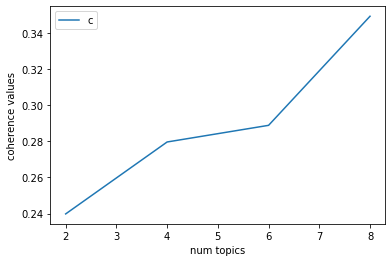

In [132]:
limit=10; start=2; step=2;
model_list, coherence_values = compute_coherence_values(gensim_dict, corpus, documents, limit, start, step)
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel('num topics')
plt.ylabel('coherence values')
plt.legend(("coherence_values"), loc="best")
plt.show()